In [1]:
import logging
import warnings
import numpy as np
import pandas as pd
import random as rd 
import KernelDensities as Kde
import SymbolicDensityRegression as sdr 
from multiprocessing import Process
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
 

def compute_quantiles(args):
    """Helper function to compute quantiles using KDE."""
    kde, distribution = args
    return [kde.get_quantiles(distribution[ind, k]) for k in range(3)]

def generate_synthetic_data(n_individuals, num_data_points):
    means_ = np.random.uniform(dist_coef[0] * mean_var, dist_coef[1] * mean_var, (n_individuals, 3))
    stds = np.random.uniform(dist_coef[0] * sigmas, dist_coef[1] * sigmas, (n_individuals, 3))
    val_means=means_
    # Reshape to enable broadcasting
    means_ = means_[:, :, np.newaxis]  # Shape (n_individuals, 3, 1)
    stds = stds[:, :, np.newaxis]  # Shape (n_individuals, 3, 1)

    uniforms = np.random.uniform(means_ - np.sqrt(3) * stds, means_ + np.sqrt(3) * stds, (n_individuals, 3, num_data_points))
    normals = np.random.normal(means_, stds, (n_individuals, 3, num_data_points))
    lognormals = np.random.lognormal(
        0.5*np.log(means_**4 / np.sqrt(stds**2 + means_**2)),
        np.sqrt(np.log(1 + (stds**2 / means_**2))),
        (n_individuals, 3, num_data_points)
    ) 
    return val_means,uniforms, normals, lognormals 
 

simulation_columns_1 = ['Simulation',
                        "Individuals",
                        'Variance factor',
                        'Num. Individuals',
                        'Num. Regressors',
                        'Num Points',
                        'Distributions',
                        'Error',
                        'Coefficient Config',
                        'K-Fold',
                        'K-Fold Repeats',
                        'FDA Train MSE',
                        'FDA Test MSE',
                        'FDA CV',
                        'FDA R2(training)',
                        'FDA R2(test)',
                        'FDA R2_functional(training)',
                        'FDA R2_functional(test)',
                        'FDA Non-Decreasing Responses',
                        'DSD Train MSE',
                        'DSD Test MSE',
                        'DSD R2 Training',
                        'DSD R2 Test', 
                        'DSD R2_v2 Training',
                        'DSD R2_v2 Test',
                        'DSD Adjusted R2 Training',
                        'DSD OOS R2 Test',
                        'DSD Coefs',
                        'Test individuals'
                    ]

def get_simulation_response(sufix,data_range, GridSize ,simulation, data_Qf, co_variables, kfoldRepeats,
                           n_individuals, n_regressors, num_data_points, CofficientsConfig,variables, response, 
                           variable,error,gen_type_des,var_factor,test_variables):
     
     logging.basicConfig(filename="simulation_get_simulation_%s.log"%sufix, level=logging.INFO, 
                                                 format="%(asctime)s - %(levelname)s - %(message)s")
     logging.info("       Start get_simulation_response (%s|%s|%s|%s) ",simulation,gen_type_des,error,var_factor)
     try:
        tr_mse,tst_mse,tr_r2,tst_r2,tr_r2_v2,tst_r2_v2,tr_r2_f,tst_r2_f,tr_r2_adj,tst_r2_oos,tr_fda_mse,tst_fda_mse,tr_fda_r2,tst_fda_r2,tr_fda_r2_f,tst_fda_r2_f,ndf_fda = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
        
        regression = sdr.SymbolicDensityRegression(GridSize,data_range)
        simulation_detail_data = []
        indivi_txt = ",".join(list(variables))
        #print(indivi_txt)
        for k in range(kfoldRepeats):
            logging.info("          K-fold (%s(%s|%s|%s|%s)) ",k,simulation,gen_type_des,error,var_factor)
            regression.update_symbolic_data(GridSize, data_range, co_variables, response, variable , data_Qf, variables)
            regression.set_train_test_variables(test_variables[k])
            regression.fit_fda()
            regression.fit_dsd()
            tr_mse.append(regression.unp_train_mse)
            tst_mse.append(regression.unp_test_mse)
            tr_r2.append(regression.dsd_r2_train)
            tst_r2.append(regression.dsd_r2_test)
            tr_r2_v2.append(regression.dsd_r2_train_v2)
            tst_r2_v2.append(regression.dsd_r2_test_v2)
            
            # tr_r2_f.append(regression.dsd_r2_train_f)
            # tst_r2_f.append(regression.dsd_r2_test_f)
            tr_r2_adj.append(regression.dsd_r2_adjust_train)
            tst_r2_oos.append(regression.dsd_r2_oos_v2)
            tr_fda_mse.append(regression.unp_fda_train_mse)
            tst_fda_mse.append(regression.unp_fda_test_mse)
            tr_fda_r2.append(regression.fda_r_2_train)
            tst_fda_r2.append(regression.fda_r_2_test)
            tr_fda_r2_f.append(regression.fda_r2_train_v2)
            tst_fda_r2_f.append(regression.fda_r_2_test_v2)
            ndf_fda.append(regression.NumberOfNonDecreasingResponses)
            
            simulation_detail_data.append(
                ("%s" % simulation,
                 indivi_txt,
                    var_factor,
                    n_individuals,
                    n_regressors,
                    num_data_points,
                    "%s" % gen_type_des,
                    error,
                    CofficientsConfig,
                    "Train-Test",
                    kfoldRepeats,
                    regression.unp_fda_train_mse,
                    regression.unp_fda_test_mse,
                    "",#regression.unp_fda_train_mse,
                    regression.fda_r_2_train,
                    regression.fda_r_2_test,
                    regression.fda_r2_train_v2,
                    regression.fda_r_2_test_v2,
                    regression.NumberOfNonDecreasingResponses,
                    regression.unp_train_mse,
                    regression.unp_test_mse,
                    regression.dsd_r2_train,
                    regression.dsd_r2_test, 
                    regression.dsd_r2_train_v2,
                    regression.dsd_r2_test_v2,
                    regression.dsd_r2_adjust_train,
                    regression.dsd_r2_oos_v2,
                    str(list([round(b,4) for b in regression.unp_b])),
                    test_variables[k],
                    ))
       
        logging.info("       Ended K-folds (%s(%s|%s|%s|%s)) ",k,simulation,gen_type_des,error,var_factor) 
        simulation_data = []
        simulation_data.append(
            ("%s" % simulation,
             indivi_txt,
                var_factor,
                n_individuals,
                n_regressors,
                num_data_points,
                "%s" % gen_type_des,
                error,
                CofficientsConfig,
                "Train-Test",
                kfoldRepeats,
                np.mean(tr_fda_mse),
                np.mean(tst_fda_mse),
                "",#regression.unp_fda_mse,
                np.mean(tr_fda_r2),
                np.mean(tst_fda_r2),
                np.mean(tr_fda_r2_f),
                np.mean(tst_fda_r2_f),
                np.mean(ndf_fda),
                np.mean(tr_mse),
                np.mean(tst_mse),
                np.mean(tr_r2),
                np.mean(tst_r2), 
                np.mean(tr_r2_v2),
                np.mean(tst_r2_v2),
                np.mean(tr_r2_adj),
                np.mean(tst_r2_oos),
                    "",
                    "",
                ))
        
        df_simulation = pd.DataFrame(
            simulation_data, columns=simulation_columns_1)
        
        df_simulation_detail = pd.DataFrame(
            simulation_detail_data, columns=simulation_columns_1)

        with open("Simulation/Simulation_%s_%s.csv" % ("Global",sufix), 'ab') as f:
            df_simulation.to_csv(
                f, header=f.tell() == 0, index=False)
        with open("Simulation/Simulation_%s_%s.csv" % ("Detail",sufix), 'ab') as f:
            df_simulation_detail.to_csv(
                f, header=f.tell() == 0, index=False)
     except Exception as exception: 
        logging.error(f"Exception occurred: {exception}", exc_info=True) 
         
def get_config_mean(ind,means_,coef):
    cf = coef[1]
    mn = sum((cf[j][0] - cf[j][1]) * means_[ind][j] for j in range(len(cf)))
    return mn + coef[0]
    #mn=0
    #cf=coef[1]
    #index=0  
    #for j in range(len(cf)):  
    #    mn=mn+(cf[j][0]-cf[j][1])*means_[ind][j]  
    #return mn+coef[0]

def get_response_aux(ind,cof,qtl):
    cof = np.array(cof)
    qtl = np.array(qtl[ind])
    mn = np.sum(cof[:, 0].reshape(-1, 1)*qtl[:, 0]+cof[:, 1].reshape(-1, 1)*qtl[:, 1], axis=0)
    return mn
    #mn=np.zeros(GridSize)
    #for t in range(len(cof)):  
    #    mn=mn+(np.multiply(cof[t][0],qtl[ind][t][0])+np.multiply(cof[t][1],qtl[ind][t][1]))
    #return mn

def get_response():
    for current_coef, cnf in enumerate(coefficients):
        v = cnf[0] * np.ones(GridSize)
        cof = cnf[1]
        df_Unif_responses[f"Y_{current_coef}"] = [v + get_response_aux(ind, cof, qtl_uniforms) for ind in range(n_individuals)]
        df_Norm_responses[f"Y_{current_coef}"] = [v + get_response_aux(ind, cof, qtl_normals) for ind in range(n_individuals)]
        df_LogNorm_responses[f"Y_{current_coef}"] = [v + get_response_aux(ind, cof, qtl_lognormals) for ind in range(n_individuals)]
    #current_coef=0
    # for cnf in coefficients:
    #     v=cnf[0]*np.ones(GridSize)
    #     cof=cnf[1]
    #     df_Unif_responses["Y_%s"%current_coef]=[v + get_response_aux(ind,cof,qtl_uniforms)  for ind in range(n_individuals)]
    #     df_Norm_responses["Y_%s"%current_coef]=[v + get_response_aux(ind,cof,qtl_normals)  for ind in range(n_individuals)]
    #     df_LogNorm_responses["Y_%s"%current_coef]=[v + get_response_aux(ind,cof,qtl_lognormals)  for ind in range(n_individuals)]
    #     current_coef=current_coef+1

def get_config_str(confg):
    b = confg[0]
    par = confg[1]
    config_str = f"$v={b}"
    config_str += "".join([f",a_{i+1}={p[0]}, b_{i+1}={p[1]}" for i, p in enumerate(par)])
    config_str += "$"
    return config_str
    # i=1
    # lst=confg
    # b=lst[0] 
    # par=lst[1] 
    # str = "$v=%s"%b
    # for i in range(len(par)):
    #     str = str + ",a_%s=%s, b_%s=%s"%((i+1),par[i][0],(i+1),par[i][1])
    # str=str+"$"
    # return(str)

def get_test_variables(variables_ind, num_test, kFold):
    test_variables = []
    current_variables = variables_ind[:]
    rd.shuffle(current_variables)
    
    for _ in range(kFold):
        if len(current_variables) > num_test:
            test_variables.append(current_variables[-num_test:])
            current_variables = current_variables[:-num_test]
        else:
            test_variables.append(rd.sample(variables_ind, k=num_test))
    
    return test_variables
    # test_variables=[]
    # current_variables=variables_ind
    # rd.shuffle(current_variables) 
    # for i in range(kFold):
    #     if len(current_variables)>num_test:
    #         test_variables.append(list(current_variables[-num_test:]))
    #         del current_variables[-num_test:]
    #     else:
    #         test_variables.append(rd.sample(variables_ind, k=num_test))
    # return test_variables
  
suffix="test"
n_simul = 20 # int(input("How Many Simulations? "))
kfoldRepeats = 10 #int(input("K-Fold Repeats? "))
num_data_points = 5000 # int(input("Num Datapoints? ")) 
n_individuals = 250 #int(input("Num individuals (m)? "))
GridSize = 1000 #int(input("GridSize? "))  # = 500
#kernel = str(input("Kernel? "))  # = 500
#if kernel=="":
kernel="gaussian"

# Configure Logging
logging.basicConfig(filename="simulation_%s.log"%suffix, level=logging.INFO, 
                    format="%(asctime)s - %(levelname)s - %(message)s")

data_range = [0.001, 1]
# Initialize KDE
thold = 0.5
kde = Kde.KernelDensities(GridSize, thold)
# Convert lists to NumPy arrays for element-wise operations
mean_var = np.array([10, 5, 20])
sigmas = np.array([6, 4, 8])
dist_coef = [0.7, 1.3]

coefficients  =[
    [-2,[[5,1]]],
    [15,[[2,3]]],
    [-10,[[7,3]]],
    [5,[[2,1],[1,3.5],[3.5,1]]],
    [6,[[15,20],[5,10],[10,1]]]
]
factors=[0.05,.30]
var_factors=[0.05,.30]
dist_coef = [0.7,1.3] 
num_reg=[1,1,1,3,3]
n_small=int(n_individuals/5)
n_individuals_small=n_small
n_test=int(n_individuals*0.2)
n_test_small=int(n_small*0.2) 
kde = Kde.KernelDensities(GridSize,thold)  
        
logging.info("==============Start Simulation ================== ") 
print(" ==============Start Simulation (================== ") 
responses_variables = ["Y"]
cols = ['Individual','Distribution']
for col in range(3):
    cols.append("X_data_%s" % (col+1))    

data_Qf_unif = pd.DataFrame(columns=cols) 
data_Qf_normal = pd.DataFrame(columns=cols)
data_Qf_log = pd.DataFrame(columns=cols)

indi=["ind%s"%i for i in range(n_individuals)]

data_Qf_unif["Individual"],data_Qf_normal["Individual"],data_Qf_log["Individual"]=indi,indi,indi 

data_Qf_unif["Distribution"]=["Uniforms"]*n_individuals
data_Qf_normal["Distribution"]=["Normals"]*n_individuals
data_Qf_log["Distribution"]=["LogNormals"]*n_individuals

cols_df = ['Individual','Distribution']  
for col in range(3):
    cols_df.append("X_%s" % (col+1)) 
    

data_unif_Qf = pd.DataFrame(columns=cols_df) 
data_normal_Qf = pd.DataFrame(columns=cols_df)
data_log_Qf = pd.DataFrame(columns=cols_df)

data_unif_Qf["Individual"],data_normal_Qf["Individual"],data_log_Qf["Individual"]=indi,indi,indi 
data_unif_Qf["Distribution"],data_normal_Qf["Distribution"],data_log_Qf["Distribution"]=["Uniforms"]*n_individuals,["Normals"]*n_individuals,["LogNormals"]*n_individuals

rd_factror=[rd.random() for _ in indi]
erros_columns=["Individual"]
responses_columns=["Individual"]
for cnf in range(len(coefficients)):
    responses_columns.append(f"Y_{cnf}")
    for mu in range(len(factors)):
        for vu in range(len(var_factors)):
            erros_columns.append(f"Y_e_{cnf}{mu}{vu}")
            responses_columns.append(f"Y_e_u_{cnf}{mu}{vu}")            
            responses_columns.append(f"Y_e_n_{cnf}{mu}{vu}")
            responses_columns.append(f"Y_e_l_{cnf}{mu}{vu}")
            

data_err_unif_Qf,data_err_normal_Qf,data_err_log_Qf = pd.DataFrame(columns=erros_columns),pd.DataFrame(columns=erros_columns),pd.DataFrame(columns=erros_columns)
df_Unif_responses,df_Norm_responses,df_LogNorm_responses = pd.DataFrame(columns=responses_columns),pd.DataFrame(columns=responses_columns),pd.DataFrame(columns=responses_columns)
data_err_unif_Qf_all,data_err_normal_Qf_all,data_err_log_Qf_all = pd.DataFrame(columns=erros_columns),pd.DataFrame(columns=erros_columns),pd.DataFrame(columns=erros_columns)
data_err_unif_Qf["Individual"],data_err_normal_Qf["Individual"],data_err_log_Qf["Individual"]=indi,indi,indi 
data_err_unif_Qf_all["Individual"],data_err_normal_Qf_all["Individual"],data_err_log_Qf_all["Individual"]=indi,indi,indi 
df_Unif_responses["Individual"],df_Norm_responses["Individual"],df_LogNorm_responses["Individual"]=indi,indi,indi 

logging.info(" \tStart - Get Synthectic Data ") 
means_,uniforms, normals, lognormals =generate_synthetic_data(n_individuals, num_data_points)
logging.info("\tEnd Distribution ") 

#stds=[[np.random.uniform(dist_coef[0]*sigmas[l],dist_coef[1]*sigmas[l]) for l in range(3)] for _ in range(n_individuals)]
err_means=[[get_config_mean(ind, means_, cnf) for cnf in coefficients] for ind in range(n_individuals)]
logging.info("\tStart Quantiles ") 
qtl_uniforms=[[kde.get_quantiles(uniforms[ind][k]) for k in range(3)] for ind in range(n_individuals)]
qtl_normals=[[kde.get_quantiles(normals[ind][k]) for k in range(3)] for ind in range(n_individuals)]
qtl_lognormals=[[kde.get_quantiles(lognormals[ind][k]) for k in range(3)] for ind in range(n_individuals)]
logging.info("\tEnd Quantiles ") 
get_response()
logging.info("\tStart Erros ") 
err_uniforms=[]
err_normals=[]
err_lognormals=[]
for ind in range(n_individuals):
    curr_u,curr_n,curr_l=[],[],[]
    for k in range(len(coefficients)):
        cf_u,cf_n,cf_l=[],[],[]
        for mu in factors:
            m_u,m_n,m_l=[],[],[]
            for vr in var_factors: 
                m_k=mu*err_means[ind][k]
                v_k=vr*m_k
                m_u.append(np.random.uniform(m_k-np.sqrt(3*v_k),m_k+np.sqrt(3*v_k),num_data_points))
                m_n.append(np.random.normal(m_k,np.sqrt(v_k),num_data_points))
                m_l.append(np.random.lognormal(0.5*np.log((m_k)**4/((v_k)+(m_k)**2)), np.sqrt(np.log(1+((v_k)/(m_k)**2))),num_data_points)) 
            cf_u.append(m_u)
            cf_n.append(m_n)
            cf_l.append(m_l)
        curr_u.append(cf_u)
        curr_n.append(cf_n)
        curr_l.append(cf_l)
    err_uniforms.append(curr_u)
    err_normals.append(curr_n)
    err_lognormals.append(curr_l)
logging.info("\tEnd Errors ") 

logging.info("\tStart Erros Qauntiles") 
for k in range(len(coefficients)): 
    for mu in range(len(factors)): 
        for vr in range(len(var_factors)): 
            data_err_unif_Qf_all["Y_e_%s%s%s"%(k,mu,vr)]=[kde.get_quantiles(err_uniforms[ind][k][mu][vr]) for ind in range(n_individuals)]
            data_err_normal_Qf_all["Y_e_%s%s%s"%(k,mu,vr)]=[kde.get_quantiles(err_normals[ind][k][mu][vr]) for ind in range(n_individuals)]
            data_err_log_Qf_all["Y_e_%s%s%s"%(k,mu,vr)]=[kde.get_quantiles(err_lognormals[ind][k][mu][vr]) for ind in range(n_individuals)]    

logging.info("\tEnd Erros Qauntiles") 
rnd=[0 if rd.random()<thold else 1 for _ in range(n_individuals)]
for k in range(len(coefficients)): 
    for mu in range(len(factors)):
        #print("Start mu=%s"%(mu))
        for vr in range(len(var_factors)): 
            data_err_unif_Qf["Y_e_%s%s%s"%(k,mu,vr)]=[data_err_unif_Qf_all["Y_e_%s%s%s"%(k,mu,vr)][i][rnd[i]] for i in range(n_individuals)]
            data_err_normal_Qf["Y_e_%s%s%s"%(k,mu,vr)]=[data_err_normal_Qf_all["Y_e_%s%s%s"%(k,mu,vr)][i][rnd[i]] for i in range(n_individuals)]
            data_err_log_Qf["Y_e_%s%s%s"%(k,mu,vr)]=[data_err_log_Qf_all["Y_e_%s%s%s"%(k,mu,vr)][i][rnd[i]] for i in range(n_individuals)] 


logging.info("\tSet error responses ") 
for k in range(len(coefficients)):
    for mu in range(len(factors)): 
        for vr in range(len(var_factors)): 
            df_Unif_responses["Y_e_u_%s%s%s"%(k,mu,vr)]=[df_Unif_responses["Y_%s"%k][ind] + data_err_unif_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind]   for ind in range(n_individuals)]
            df_Unif_responses["Y_e_n_%s%s%s"%(k,mu,vr)]=[df_Unif_responses["Y_%s"%k][ind] + data_err_normal_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind]   for ind in range(n_individuals)]
            df_Unif_responses["Y_e_l_%s%s%s"%(k,mu,vr)]=[df_Unif_responses["Y_%s"%k][ind] + data_err_log_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind]  for ind in range(n_individuals)]
            
            df_Norm_responses["Y_e_u_%s%s%s"%(k,mu,vr)]=[df_Norm_responses["Y_%s"%k][ind] + data_err_unif_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]
            df_Norm_responses["Y_e_n_%s%s%s"%(k,mu,vr)]=[df_Norm_responses["Y_%s"%k][ind] + data_err_normal_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]
            df_Norm_responses["Y_e_l_%s%s%s"%(k,mu,vr)]=[df_Norm_responses["Y_%s"%k][ind] + data_err_log_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]
            
            df_LogNorm_responses["Y_e_u_%s%s%s"%(k,mu,vr)]=[df_LogNorm_responses["Y_%s"%k][ind] + data_err_unif_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]
            df_LogNorm_responses["Y_e_n_%s%s%s"%(k,mu,vr)]=[df_LogNorm_responses["Y_%s"%k][ind] + data_err_normal_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]
            df_LogNorm_responses["Y_e_l_%s%s%s"%(k,mu,vr)]=[df_LogNorm_responses["Y_%s"%k][ind] + data_err_log_Qf["Y_e_%s%s%s"%(k,mu,vr)][ind] for ind in range(n_individuals)]      

logging.info("\tEnded Set error responses ")  
variables_ind=["ind%s"%i for i in range(n_individuals)]
all_individuals=["ind%s"%i for i in range(n_individuals)]

rd.shuffle(all_individuals)
small_sample_individuals = list(all_individuals[-n_small:])
all_small_sample_individuals = list(all_individuals[-n_small:])
logging.info("\tGet error Sets ") 
test_variables=get_test_variables(all_individuals, n_test, kfoldRepeats)
test_variables_small=get_test_variables(all_small_sample_individuals, n_test_small, kfoldRepeats)
logging.info("\tEnded Get error Sets ")
print("######################## Start Fitting Models   ##################################") 
logging.info("     ######################## Start Fitting Models  ################################## ")

 ==============Start Simulation (================== 
######################## Start Fitting Models   ##################################


In [5]:
import matplotlib.pyplot as plt

In [6]:
def get_points(lower, upper, n):
    """General function to get n points between lower and upper

    Args:
        lower (number): lower limit
        upper (number): upper limit
        n (int): number of points to generate

    Returns:
        list: list of generated values
    """
    delta = (upper - lower) / n
    p = []
    for i in range(n):
        p.append(lower + i * delta)

    return np.array(p)

In [7]:
points_QF = get_points(0.001,1, GridSize)

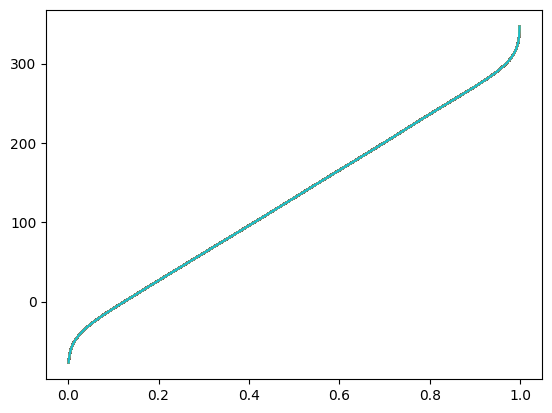

In [10]:
for i in range(n_individuals):
    plt.plot(points_QF,df_Unif_responses["Y_e_u_%s%s%s"%(0,1,0)][2])

plt.show()